In [ ]:
!pip install bitsandbytes

In [11]:
import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
import numpy as np

############ Quantization #####################
# from transformers import BitsAndBytesConfig
# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# model = VisionEncoderDecoderModel.from_pretrained('/kaggle/input/caption/pytorch/default/1/kaggle/working/VIT_small_distilgpt',\
#                                                  quantization_config=quantization_config)
#model.save_pretrained("quantized_bitsandbytes")
########################################

model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/caption/pytorch/default/1/kaggle/working/VIT_small_distilgpt")
feature_extractor = ViTFeatureExtractor.from_pretrained("WinKawaks/vit-small-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# from torch.quantization import quantize_dynamic

# # Quantize the trained model
# quantized_model = quantize_dynamic(
#     model,
#     dtype=torch.qint8,
#     inplace=False
# )

# torch.save(quantized_model.state_dict(), "quantized_model.pth")
# torch.save(quantized_model, "quantized_model_full.bin")

Image downloaded successfully!


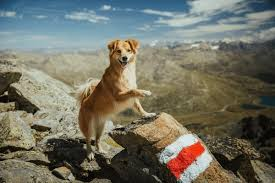

In [12]:
img_link = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTdCmN_tZ9dFsLlk3VxVYOEKtC5Lfc3ns_rqg&s"

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    return image

def generate_caption(image_path):
    image = load_image(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    
    # Generate output
    with torch.no_grad():
        output_ids = model.generate(
            pixel_values,
            max_length=10,
            top_k=1000,
            do_sample=False,
            top_p=0.95,
            num_return_sequences=1
        )
    
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption
    
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    x = np.sqrt(activations.shape[1])
    activations = activations.view(activations.shape[0], int(x), int(x), activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

def get_generated_tokens(image, model, processor):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    # Forward pass
    generated_tokens = model.generate(pixel_values=pixel_values, max_length=50)
    return generated_tokens, pixel_values

last_layer_output = None
def get_activations_and_gradient(pixel_values, model, processor, generated_tokens, layer_name, token_index = 0):
    
    text = processor.decode(generated_tokens[0, token_index], skip_special_tokens=False)
    def save_output(module, input, output):
        global last_layer_output
        last_layer_output = output
        output.retain_grad()
    
    last_layer = layer_name
    last_layer.register_forward_hook(save_output)
    outputs = model(pixel_values=pixel_values, decoder_input_ids=generated_tokens[:, :-1], return_dict=True)

    # Backward pass on a selected logit
    selected_logit = outputs.logits[0, token_index, generated_tokens[0, token_index]]
    selected_logit.backward()

    return last_layer_output, last_layer_output.grad, text

def apply_gradcam(layer_output, grad, image, index, text):
    from skimage import color
    transform_output = reshape_transform_vit_huggingface(layer_output)
    transform_grad = reshape_transform_vit_huggingface(grad)
    weights = torch.mean(transform_grad, dim=(2, 3), keepdim=True)  # Average across the spatial dimensions

    # Step 2: Weighted combination of activation maps
    grad_cam = torch.sum(weights * transform_output, dim=1, keepdim=True)  # Sum over the feature maps

    # Step 3: Apply ReLU
    grad_cam = torch.relu(grad_cam)  # Only take positive contributions
    grad_cam = grad_cam.squeeze(0)  # Remove batch dimension for visualization

    # Step 4: Normalize (optional but helps in visualization)
    grad_cam = grad_cam / grad_cam.max()
    heatmap = torch.nn.functional.interpolate(grad_cam.unsqueeze(0), size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)
    heatmap = heatmap.squeeze().detach().numpy()

    blended = Image.blend(image.convert('RGBA'), Image.fromarray((plt.cm.jet(heatmap)* 255).astype(np.uint8)).convert('RGBA'), alpha=0.5)
    blended.save(f"blended_image_{index}.png", format='PNG')
    return {f"{text}": f"blended_image_{index}.png"}

import requests
url = img_link
response = requests.get(url, stream=True)

if response.status_code == 200:
    with open('/kaggle/working/download.jpg', 'wb') as file:
        file.write(response.content)
    print("Image downloaded successfully!")
else:
    print("Failed to download image. Status code:", response.status_code)
    
image =  Image.open("/kaggle/working/download.jpg").convert("RGB")
image

In [13]:
layer_name = model.encoder.encoder.layer[-1].output
generated_tokens, pixel_values = get_generated_tokens(image, model, feature_extractor)

[tokenizer.decode(token) for token in generated_tokens]

['<|endoftext|>A white dog is standing on top of a rock with a blue sky in the background . . . looking at the camera . . " . . a white dog with a red collar is standing in front of a mountain . . , with mountains in']

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

visualizations = []

for index, tokens in enumerate(generated_tokens[:, :-1].numpy().tolist()[0]):
    layer_output, grad, text = get_activations_and_gradient(pixel_values, model, tokenizer, generated_tokens, layer_name, token_index=index)
    data = apply_gradcam(layer_output, grad, image, index, text)
    visualizations.append(data)

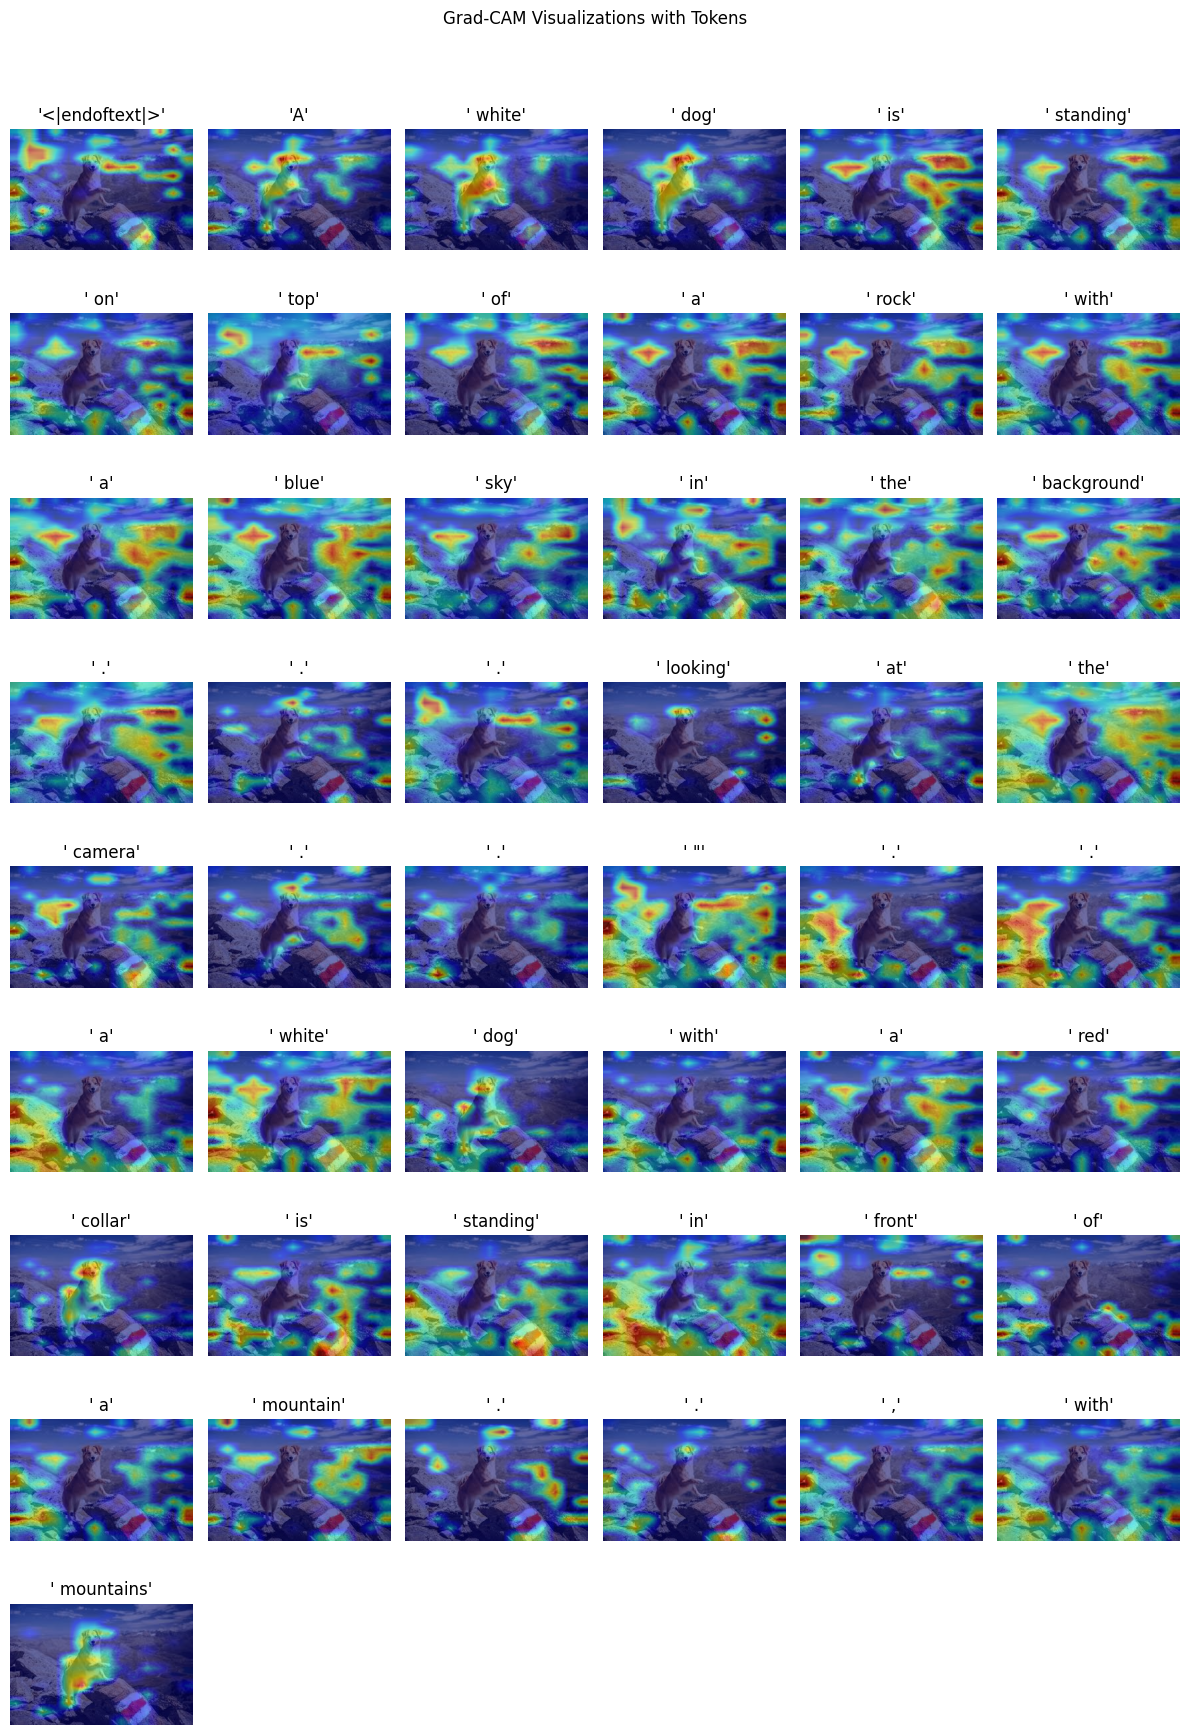

In [15]:
num_images = len(visualizations)
columns = 6
rows = (num_images + columns - 1) // columns 


fig, axs = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
fig.suptitle("Grad-CAM Visualizations with Tokens")

for i, data in enumerate(visualizations):
    key = list(data.keys())[0]
    img = mpimg.imread(data[key])
    row, col = divmod(i, columns)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f"'{key}'")
    axs[row, col].axis("off")


for j in range(i + 1, rows * columns):
    fig.delaxes(axs[j // columns, j % columns])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()